# 基于泰坦尼克号生还数据，对生还可能性进行预测

### 目标：
####    1、得出与幸存相关性较大的因素
####    2、建模预测生还人数

### 流程：
####    1、导入数据
####    2、加工清洗数据
####    3、初步分析（可视化）
####    4、建模预测

##### 1、导入需使用库

In [4]:
#数据清洗与初步分析
import pandas as pd
import numpy as np
import random as rnd

#数据可视化
import matplotlib.pyplot as plt
import seaborn as sns

#建模库
from sklearn.linear_model import LogisticRegression

#### 2、导入数据并观察

In [81]:
df_train = pd.read_csv(r'C:\Users\WS\Desktop\train.csv')
df_test = pd.read_csv(r'C:\Users\WS\Desktop\test.csv')

In [82]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [84]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [85]:
df_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

train有十二个特征，test有十一个特征，缺少的是Survived（人工测试集）

In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [87]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


train缺失数据为Age、Cabin、Embarked， test缺失数据为Age、Fare、Cabin

train有八百多条数据，test有四百多条数据，这里不选择合并

#### 特征解读

In [88]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


初步猜想：
    相关因素为：年龄、性别、仓位等级、所在船舱及亲人数

#### 3、相关性检验

使用透视图分析特征之间的相关性

In [89]:
#仓位等级与生还率
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [90]:
#性别生还率
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [91]:
#堂兄妹数与生还率
df_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [92]:
#父母子女数与生还率
df_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


可视化相关性分析

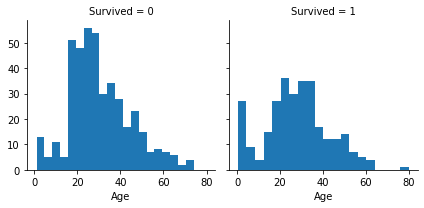

In [93]:
#年龄
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

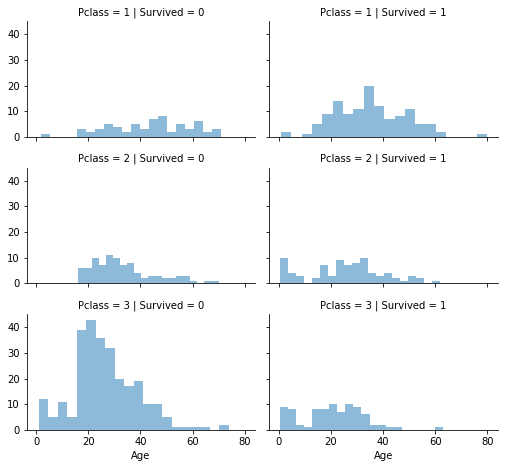

In [94]:
#船舱等级
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()
plt.show()

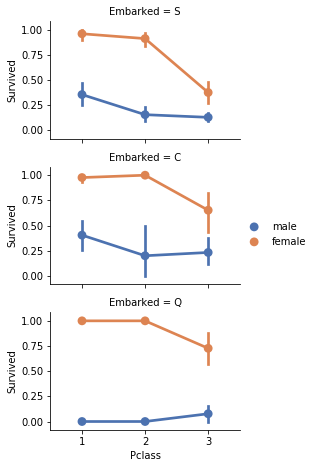

In [95]:
#登船港口
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex',order=[1,2,3],hue_order=df_train.Sex.unique(),palette='deep')
grid.add_legend()
plt.show()

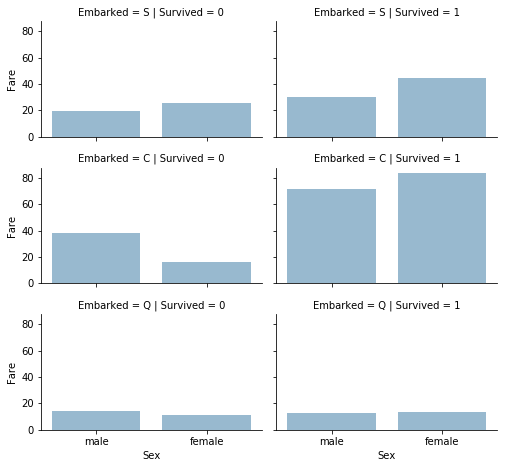

In [96]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', order=df_train.Sex.unique(),alpha=.5, ci=None)
grid.add_legend()
plt.show()

#### 4、数据处理

In [97]:
#删除 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked' 数据
train_df = df_train.drop(['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1)
test_df = df_test.drop(['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1)

In [98]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,male,22.0,1,0
1,2,1,1,female,38.0,1,0
2,3,1,3,female,26.0,0,0
3,4,1,1,female,35.0,1,0
4,5,0,3,male,35.0,0,0


In [99]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch
0,892,3,male,34.5,0,0
1,893,3,female,47.0,1,0
2,894,2,male,62.0,0,0
3,895,3,male,27.0,0,0
4,896,3,female,22.0,1,1


In [100]:
combine = [train_df, test_df]

转换性别特征 女为1 男为0

In [101]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female':1, 'male':0}).astype(int)

In [102]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,0,22.0,1,0
1,2,1,1,1,38.0,1,0
2,3,1,3,1,26.0,0,0
3,4,1,1,1,35.0,1,0
4,5,0,3,0,35.0,0,0


补全缺失值Age

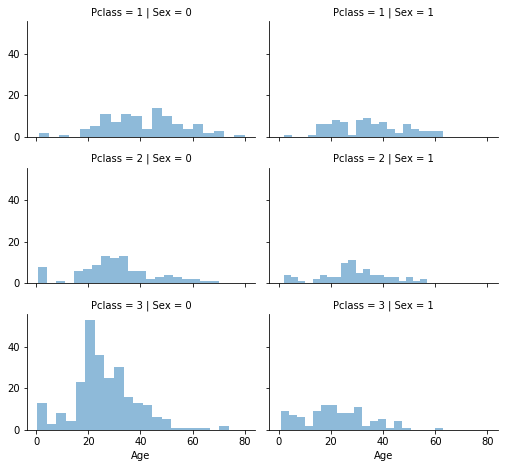

In [104]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()
plt.show()

In [105]:
#创建pclass与gender的组合空数组预测年龄
guess_ages = np.zeros((2, 3))

#对sex（0、1）和pclass（1、2、3）进行迭代，
#计算得出6种组合下得到的age预测值
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            #将随机年龄浮动转换为最接近的.5年龄
            guess_ages[i, j] = int(age_guess / 0.5 + 0.5) * 0.5

    for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),
                             'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

In [106]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,0,22,1,0
1,2,1,1,1,38,1,0
2,3,1,3,1,26,0,0
3,4,1,1,1,35,1,0
4,5,0,3,0,35,0,0


对Age分段，查看与Survived之间的相关性

In [107]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


对分段进行处理

In [110]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
    
#抛弃AgeBand
train_df = train_df.drop(['AgeBand'], axis = 1)
combine = [train_df, test_df]

In [111]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,0,0,1,0
1,2,1,1,1,0,1,0
2,3,1,3,1,0,0,0
3,4,1,1,1,0,1,0
4,5,0,3,0,0,0,0


将两个亲人数指标进行组合

In [112]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


创建一个指标来查看是否独自一人的生还率相关性

In [114]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [ ]:
#抛弃几个特征，留下IsAlone
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

In [118]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,IsAlone
0,1,0,3,0,0,0
1,2,1,1,1,0,0
2,3,1,3,1,0,1
3,4,1,1,1,0,0
4,5,0,3,0,0,1


绘制相关性表

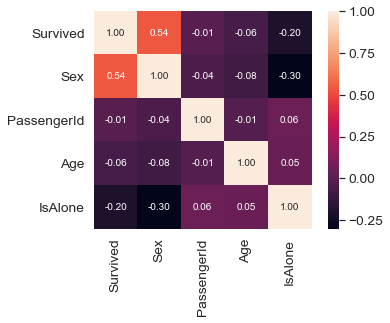

In [123]:
corrmat = train_df.corr()

k = 5

#取出与Survived相关性最大的十项
cols = corrmat.nlargest(k,'Survived')['Survived'].index  
#相关系数 
cm = np.corrcoef(train_df[cols].values.T)  
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm,cbar = True,annot = True,square = True ,fmt = '.2f',annot_kws = {'size': 10},yticklabels = cols.values,xticklabels = cols.values)
plt.show()

#### 5、建模预测

使用逻辑回归建模预测分析（因为我不会其他模型。。）

In [126]:
#数据集划分
X_train = train_df.drop(['Survived', 'PassengerId'], axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 4), (891,), (418, 4))

In [130]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print("逻辑回归预测得分：", acc_log)

逻辑回归预测得分： 78.68


c:\users\ws\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [131]:
#计算特征值系数验证假设
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Pclass,2.509983
2,Sex,-0.020072
3,Age,-0.093521
0,Survived,-0.932548
4,IsAlone,NaN


#### 结论：
##### 1、Pclass为最高正系数，表明Pclass的值增加，Survived=1的概率增加
##### 2、其他都为负系数，呈反比关系
##### 3、预测准确度得分为78.68